In [1]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import os
# 한글 폰트 설정하기
fontpath = '/usr/share/fonts/truetype/Nanum/NanumGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=10)
plt.rc('font', family='Nanum')
matplotlib.font_manager._rebuild()

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim

import torchvision
from torchvision import datasets, models, transforms

import numpy as np
import time


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # device 객체
print(device)

cuda:0


In [35]:
from PIL import Image
import os, glob
import numpy as np
from sklearn.model_selection import train_test_split

In [36]:
car_dir = './class_2nd/train'
categories = os.listdir(car_dir)
categories.remove('.DS_Store')
nb_classes = len(categories)
print(nb_classes, categories)

30 ['현대 코나', '쌍용 렉스턴 스포츠', '현대 코나 일렉트릭', '르노삼성 SM6', '현대 싼타페TM', '제네시스 G80', '기아 니로', '기아 레이', '현대 팰리 세이드', '기아 K7 YG', '기아 봉고3', '제네시스 G90', '현대 그랜저 IG', '쌍용 G4 렉스턴', '기아 셀토스', '기아 모하비', '현대 그랜드 스타렉스', '현대 포터2', '쉐보레 트랙스', '기아 모닝 JA', '현대 LF 쏘나타', '기아 카니발', '기아 쏘렌토', '기아 K5 JF', '쉐보레 스파크', '르노삼성 QM3', '기아 K3 BD', '쌍용 티볼리', '르노삼성 QM6', '현대 베뉴']


In [37]:
# 이미지 크기 지정
image_w = 224
image_h = 224
pixels = image_w * image_h *3

In [38]:
transforms_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(), # 데이터 증진(augmentation)
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # 정규화(normalization)
])

transforms_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# transforms_val = transforms.Compose([
#     transforms.Resize((380, 380), Image.ANTIALIAS),
#     transforms.ToTensor(),
#     transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
# ])
data_dir = './class_2nd'
train_datasets = datasets.ImageFolder(os.path.join(data_dir, 'train'), transforms_train)
test_datasets = datasets.ImageFolder(os.path.join(data_dir, 'test'), transforms_test)
# val_datasets = datasets.ImageFolder(os.path.join(data_dir, 'val'), transforms_val)


train_dataloader = torch.utils.data.DataLoader(train_datasets, batch_size=32, shuffle=True, num_workers=4)
test_dataloader = torch.utils.data.DataLoader(test_datasets, batch_size=32, shuffle=True, num_workers=4)
# val_dataloader = torch.utils.data.DataLoader(val_datasets, batch_size=12, shuffle=True, num_workers=4)

class_names = train_datasets.classes
class_cnt = len(class_names)


print('학습 데이터셋 크기:', len(train_datasets))
print('차종 모델명 :', class_names)
print('차종 개수 : ', class_cnt )

학습 데이터셋 크기: 5035
차종 모델명 : ['기아 K3 BD', '기아 K5 JF', '기아 K7 YG', '기아 니로', '기아 레이', '기아 모닝 JA', '기아 모하비', '기아 봉고3', '기아 셀토스', '기아 쏘렌토', '기아 카니발', '르노삼성 QM3', '르노삼성 QM6', '르노삼성 SM6', '쉐보레 스파크', '쉐보레 트랙스', '쌍용 G4 렉스턴', '쌍용 렉스턴 스포츠', '쌍용 티볼리', '제네시스 G80', '제네시스 G90', '현대 LF 쏘나타', '현대 그랜드 스타렉스', '현대 그랜저 IG', '현대 베뉴', '현대 싼타페TM', '현대 코나', '현대 코나 일렉트릭', '현대 팰리 세이드', '현대 포터2']
차종 개수 :  30


In [39]:
model = models.densenet161(pretrained=True)

In [40]:
print(model)

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(96, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(192, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(144, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (rel

In [41]:
# model = models.efficientnetb0(pretrained=True)
num_features = model.classifier.in_features
# 전이 학습(transfer learning): 모델의 출력 뉴런 수를 6개로 교체하여 마지막 레이어 다시 학습
model.fc = nn.Linear(num_features, class_cnt)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [42]:
num_epochs = 15
model.train()
start_time = time.time()

# 전체 반복(epoch) 수 만큼 반복하며
for epoch in range(num_epochs):
    running_loss = 0.
    running_corrects = 0

    # 배치 단위로 학습 데이터 불러오기
    for inputs, labels in train_dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        # 모델에 입력(forward)하고 결과 계산
        optimizer.zero_grad()
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        # 역전파를 통해 기울기(gradient) 계산 및 학습 진행
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

    epoch_loss = running_loss / len(train_datasets)
    epoch_acc = running_corrects / len(train_datasets) * 100.

    # 학습 과정 중에 결과 출력
    print('#{} Loss: {:.4f} Acc: {:.4f}% Time: {:.4f}s'.format(epoch, epoch_loss, epoch_acc, time.time() - start_time))

#0 Loss: 2.4445 Acc: 52.7507% Time: 65.4214s
#1 Loss: 0.3769 Acc: 91.3208% Time: 130.8553s
#2 Loss: 0.1477 Acc: 97.0804% Time: 196.2809s
#3 Loss: 0.0805 Acc: 98.3913% Time: 261.6978s
#4 Loss: 0.0505 Acc: 99.2056% Time: 327.1652s
#5 Loss: 0.0330 Acc: 99.4638% Time: 392.5855s
#6 Loss: 0.0259 Acc: 99.5631% Time: 458.0082s
#7 Loss: 0.0233 Acc: 99.6226% Time: 523.4563s
#8 Loss: 0.0179 Acc: 99.7021% Time: 588.9626s
#9 Loss: 0.0147 Acc: 99.7219% Time: 654.4110s
#10 Loss: 0.0142 Acc: 99.7418% Time: 719.8734s
#11 Loss: 0.0136 Acc: 99.7617% Time: 785.3581s
#12 Loss: 0.0129 Acc: 99.6822% Time: 850.8423s
#13 Loss: 0.0115 Acc: 99.7219% Time: 916.3078s
#14 Loss: 0.0107 Acc: 99.7219% Time: 981.7952s


In [46]:
num_epochs = 5
model.train()
start_time = time.time()

# 전체 반복(epoch) 수 만큼 반복하며
for epoch in range(num_epochs):
    running_loss = 0.
    running_corrects = 0

    # 배치 단위로 학습 데이터 불러오기
    for inputs, labels in train_dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        # 모델에 입력(forward)하고 결과 계산
        optimizer.zero_grad()
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        # 역전파를 통해 기울기(gradient) 계산 및 학습 진행
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

    epoch_loss = running_loss / len(train_datasets)
    epoch_acc = running_corrects / len(train_datasets) * 100.

    # 학습 과정 중에 결과 출력
    print('#{} Loss: {:.4f} Acc: {:.4f}% Time: {:.4f}s'.format(epoch, epoch_loss, epoch_acc, time.time() - start_time))

#0 Loss: 0.0109 Acc: 99.7021% Time: 65.4867s
#1 Loss: 0.0099 Acc: 99.7617% Time: 130.9265s
#2 Loss: 0.0089 Acc: 99.7418% Time: 196.3583s
#3 Loss: 0.0088 Acc: 99.7021% Time: 261.7789s
#4 Loss: 0.0087 Acc: 99.7021% Time: 327.2076s


In [47]:
# 모델 저장
torch.save(model, './models/car_densenet161_ver02_20.ph')

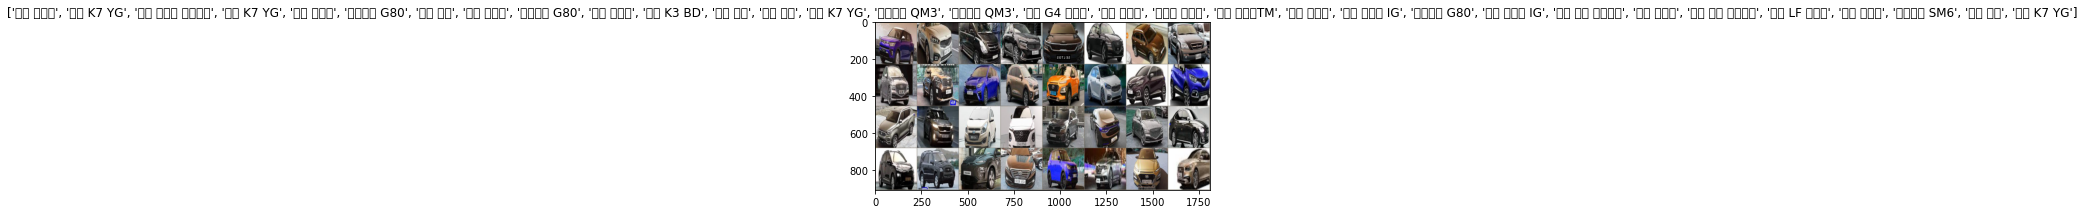

In [48]:
def imshow(input, title):
    # torch.Tensor를 numpy 객체로 변환
    input = input.numpy().transpose((1, 2, 0))
    # 이미지 정규화 해제하기
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    input = std * input + mean
    input = np.clip(input, 0, 1)
    # 이미지 출력
    plt.imshow(input)
    plt.title(title)
    plt.show()


# 학습 데이터를 배치 단위로 불러오기
iterator = iter(train_dataloader)

# 현재 배치를 이용해 격자 형태의 이미지를 만들어 시각화
inputs, classes = next(iterator)
out = torchvision.utils.make_grid(inputs)
imshow(out, title=[class_names[x] for x in classes])

[예측 결과: 르노삼성 QM6] (실제 정답: 현대 싼타페TM)


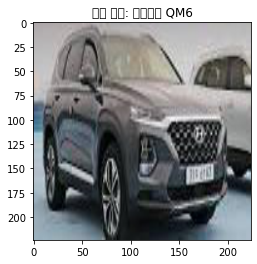

[예측 결과: 제네시스 G80] (실제 정답: 제네시스 G80)


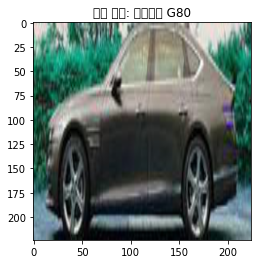

[예측 결과: 현대 싼타페TM] (실제 정답: 현대 싼타페TM)


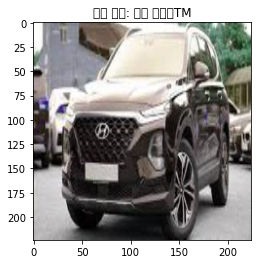

[예측 결과: 기아 K3 BD] (실제 정답: 기아 K3 BD)


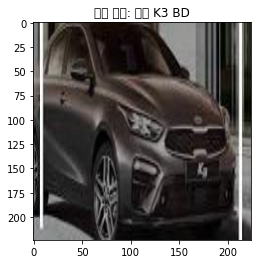

[예측 결과: 현대 LF 쏘나타] (실제 정답: 현대 LF 쏘나타)


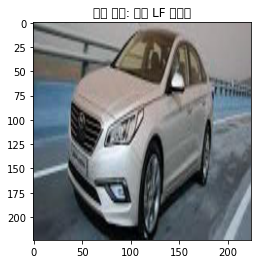

[예측 결과: 르노삼성 QM3] (실제 정답: 르노삼성 QM3)


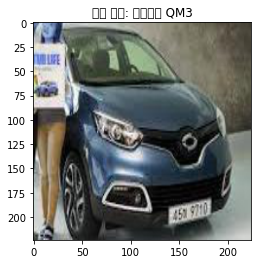

[예측 결과: 기아 쏘렌토] (실제 정답: 기아 모하비)


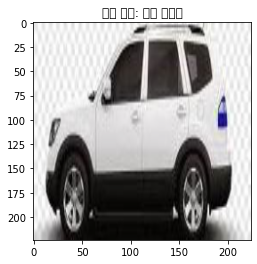

[예측 결과: 제네시스 G90] (실제 정답: 제네시스 G90)


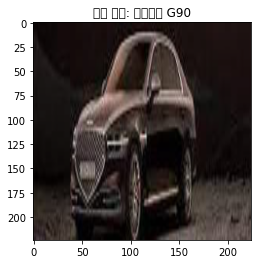

[예측 결과: 기아 니로] (실제 정답: 기아 니로)


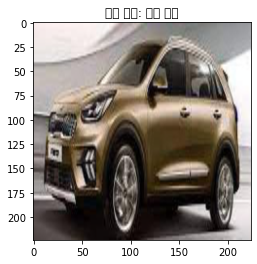

[예측 결과: 현대 싼타페TM] (실제 정답: 현대 싼타페TM)


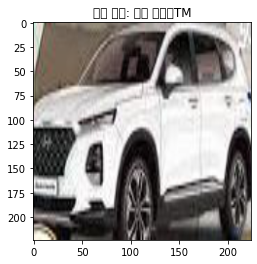

[예측 결과: 현대 코나] (실제 정답: 현대 코나)


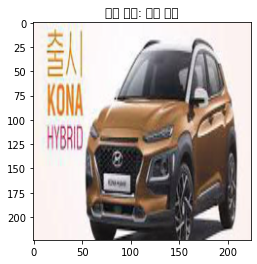

[예측 결과: 기아 셀토스] (실제 정답: 기아 셀토스)


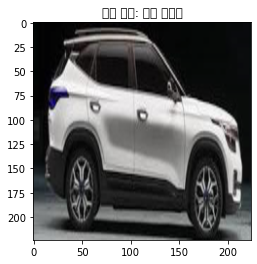

[예측 결과: 현대 베뉴] (실제 정답: 현대 베뉴)


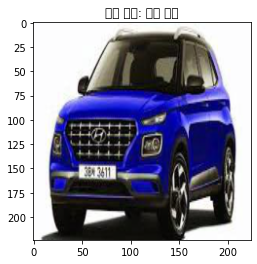

[예측 결과: 기아 K5 JF] (실제 정답: 기아 K5 JF)


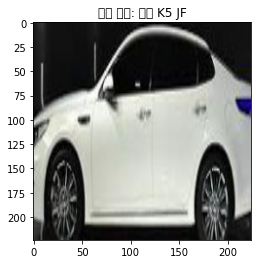

[예측 결과: 현대 그랜저 IG] (실제 정답: 현대 그랜저 IG)


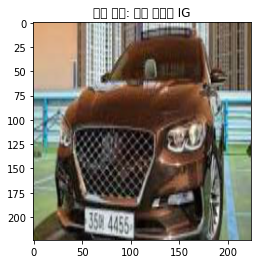

[예측 결과: 현대 코나] (실제 정답: 현대 코나)


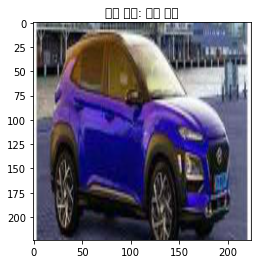

[예측 결과: 기아 니로] (실제 정답: 기아 니로)


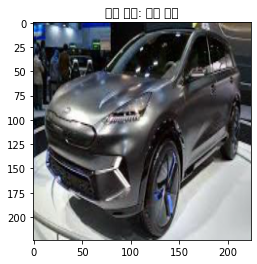

[예측 결과: 쌍용 렉스턴 스포츠] (실제 정답: 쌍용 렉스턴 스포츠)


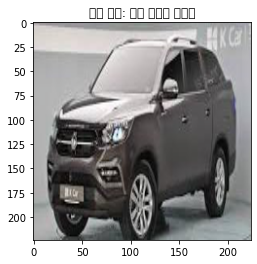

[예측 결과: 르노삼성 QM3] (실제 정답: 르노삼성 QM3)


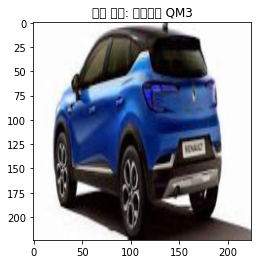

[예측 결과: 기아 K7 YG] (실제 정답: 기아 K7 YG)


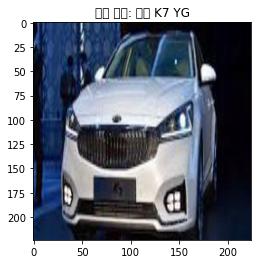

[예측 결과: 현대 팰리 세이드] (실제 정답: 현대 팰리 세이드)


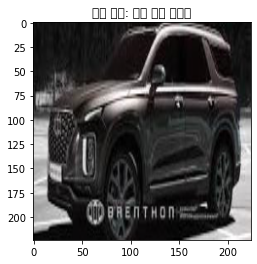

[예측 결과: 제네시스 G90] (실제 정답: 제네시스 G90)


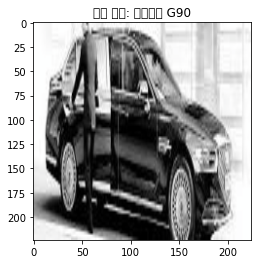

[예측 결과: 기아 K3 BD] (실제 정답: 기아 K3 BD)


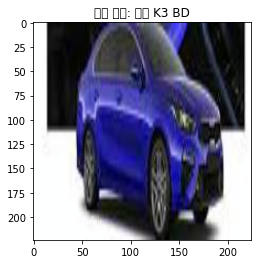

[예측 결과: 기아 니로] (실제 정답: 기아 니로)


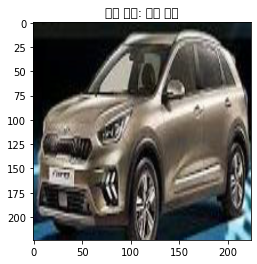

[예측 결과: 제네시스 G80] (실제 정답: 쉐보레 스파크)


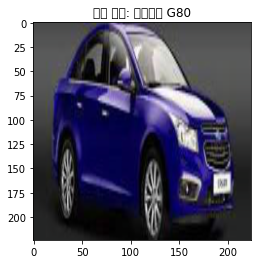

[예측 결과: 기아 K3 BD] (실제 정답: 기아 K3 BD)


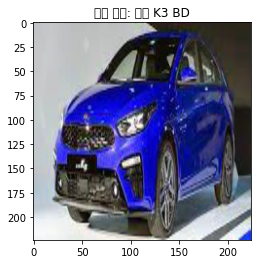

[예측 결과: 기아 셀토스] (실제 정답: 르노삼성 QM6)


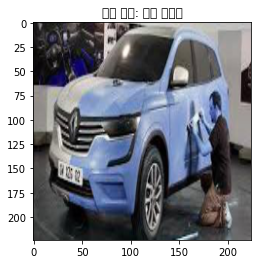

[예측 결과: 기아 쏘렌토] (실제 정답: 기아 쏘렌토)


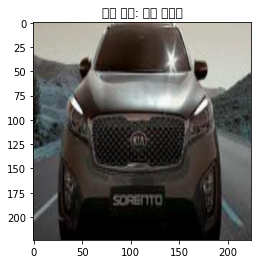

[예측 결과: 쉐보레 스파크] (실제 정답: 쉐보레 스파크)


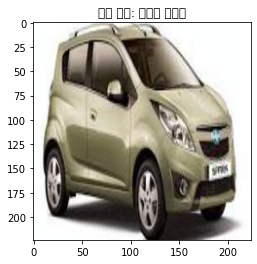

[예측 결과: 제네시스 G80] (실제 정답: 제네시스 G80)


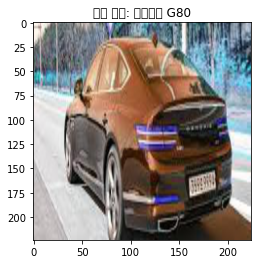

[예측 결과: 현대 코나] (실제 정답: 현대 코나)


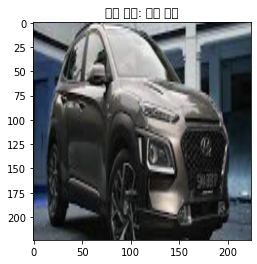

[예측 결과: 르노삼성 QM6] (실제 정답: 르노삼성 QM6)


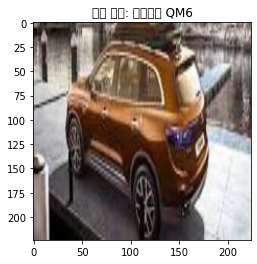

[예측 결과: 현대 그랜저 IG] (실제 정답: 현대 그랜저 IG)


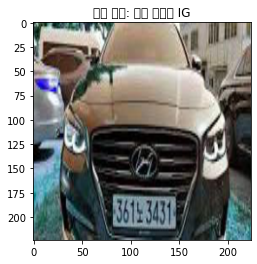

[예측 결과: 현대 LF 쏘나타] (실제 정답: 현대 그랜저 IG)


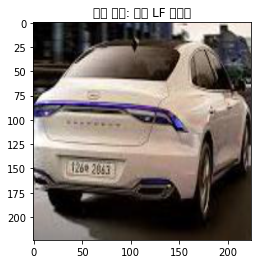

[예측 결과: 쌍용 렉스턴 스포츠] (실제 정답: 기아 셀토스)


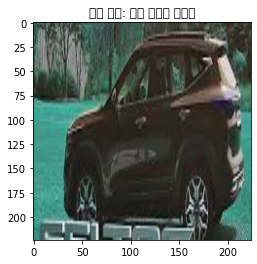

[예측 결과: 르노삼성 QM6] (실제 정답: 르노삼성 QM6)


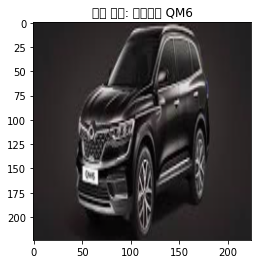

[예측 결과: 르노삼성 QM3] (실제 정답: 현대 그랜저 IG)


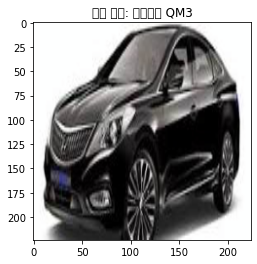

[예측 결과: 기아 셀토스] (실제 정답: 기아 셀토스)


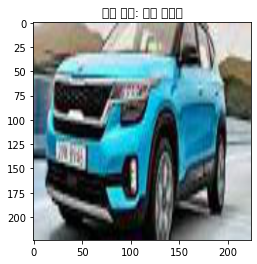

[Test Phase] Loss: 0.3588 Acc: 91.8046% Time: 11.4453s


In [49]:
model.eval()
start_time = time.time()

with torch.no_grad():
    running_loss = 0.
    running_corrects = 0

    for inputs, labels in test_dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

        # 한 배치의 첫 번째 이미지에 대하여 결과 시각화
        print(f'[예측 결과: {class_names[preds[0]]}] (실제 정답: {class_names[labels.data[0]]})')
        imshow(inputs.cpu().data[0], title='예측 결과: ' + class_names[preds[0]])

    epoch_loss = running_loss / len(test_datasets)
    epoch_acc = running_corrects / len(test_datasets) * 100.
    print('[Test Phase] Loss: {:.4f} Acc: {:.4f}% Time: {:.4f}s'.format(epoch_loss, epoch_acc, time.time() - start_time))